In [1]:
import matplotlib.pyplot as plt
import scienceplots
import time
import edist.ted as ted
import joblib

# try to load data
import os

import hyperelastic_laws as hyperelastic
import torch
import sympy 
from sympy import Pow, MatrixSymbol, Trace, log, MatMul
import numpy as np
import symengine as se
from sympy.parsing.sympy_parser import parse_expr

import tree

import cma

import recursive_tree_grammar_auto_encoder as rtg_ae

In [2]:
plt.style.use(['science', 'nature'])
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 17,
                      'lines.linewidth': 2,
                      'axes.labelsize': 17,  
                      'axes.titlesize': 17,
                      'xtick.labelsize':17,
                      'ytick.labelsize':17,
                      'axes.linewidth': 2})
plt.rcParams.update({'figure.dpi': '150'})


In [3]:
dim = 128
dim_vae  = 8
num_params = 0
model = rtg_ae.TreeGrammarAutoEncoder(hyperelastic.grammar, dim = dim, dim_vae = dim_vae)
for key in model.state_dict():
    num_params += model.state_dict()[key].numel()
print('The model contains %d parameters' % (num_params))

The model contains 402080 parameters


In [4]:
def to_algebraic_string(nodes, adj, i = 0):
    if list(',') in list(map(str.split, nodes[i])):
        return list(map(str.split, str(nodes[i])))[0][0] + '.'+ list(map(str.split, str(nodes[i])))[2][0]
    if nodes[i] == '+' or nodes[i] == '*' or nodes[i] == '-'  or nodes[i] == '/':
        return to_algebraic_string(nodes, adj, adj[i][0]) + ' ' + nodes[i] + ' ' + to_algebraic_string(nodes, adj, adj[i][1])
    if nodes[i] == 'log' or nodes[i] == 'exp':
        return nodes[i] + '(' + to_algebraic_string(nodes, adj, adj[i][0]) + ')'
    if nodes[i] == 'pow':
        return '(' + to_algebraic_string(nodes, adj, adj[i][0]) + ')' + '**' + to_algebraic_string(nodes, adj, adj[i][1])
    if nodes[i] == '(J-1)':
        return '(' + nodes[i] + ')' 
    if nodes[i] == '(I1-3)':
        return '(' + 'I1-3' + ')' 
    if nodes[i] == '(I2-3)':
        return '(' + 'I2-3' + ')'
    else:
        return nodes[i]

def evaluate_se(nodes, adj, I1_tilde, I2_tilde, J_tilde, F11_tilde, F22_tilde, F33_tilde, train=False):
    J, I1, I2 = se.symbols("J I1 I2")
    sympy_expression = se.sympify(to_algebraic_string(nodes,adj))
    y_all = np.zeros_like(I1_tilde)
    for i in range(0, I1_tilde.shape[0]):
        y_all[i] = np.array(sympy_expression.subs({J:se.Pow(se.sqrt(J_tilde[i]),2), I1:se.Pow(se.sqrt(I1_tilde[i]),2), I2:se.Pow(se.sqrt(I2_tilde[i]),2)}).evalf(16)).astype(np.float128)
    return y_all

def objective_function(nodes, adj, I1_tilde, I2_tilde, J_tilde, F11_tilde, F22_tilde, F33_tilde, y):
    y_pred = evaluate_se(nodes, adj, I1_tilde, I2_tilde, J_tilde, F11_tilde, F22_tilde, F33_tilde, train=True)
    return np.sqrt(np.mean((y - y_pred) ** 2 ))

In [5]:
def get_I1(J, C):
    I1 = Pow(J,-2/3)*(C[0,0] + C[1,1] + 1.)
    return I1

def get_I2(J, C):
    I2 = Pow(J,-4/3)*(C[0,0] + C[1,1] -C[0,1]*C[1,0] + C[0,0]*C[1,1])
    return I2

def get_Ogden(J, C):
    kappa_ogden = 1.5
    mu_ogden = 0.65
    alpha_ogden = 0.65
    I1 = C[0,0] + C[1,1] + 1.
    I1_tilde = J**(-2/3)*I1 + 0.0000001
    I1t_0 = 3 + 0.00000001
    J_0 = 1 + 0.0000001
    W_offset = kappa_ogden*(J_0-1)**2 + 1/alpha_ogden * 2. * (0.5**alpha_ogden*(I1t_0  +  sympy.sqrt(  (I1t_0-1/(J_0**(2./3.)))**2 - 4*J_0**(2./3.)) - 1/(J_0**(2./3.)) )**alpha_ogden+( 0.5*I1t_0 - 0.5*sympy.sqrt(  (I1t_0-1/(J_0**(2./3.)))**2 - 4*J_0**(2./3.))  - 0.5/(J_0**(2./3.)) )**alpha_ogden + J_0**(-alpha_ogden*2./3.) ) * mu_ogden
    W_truth = kappa_ogden*(J-1)**2 + 1/alpha_ogden * 2. * (0.5**alpha_ogden*(I1_tilde  +  sympy.sqrt(  (I1_tilde- J**(-2./3.))**2 \
            - 4*J**(2./3.)) - J**(-2./3.) )**alpha_ogden+( 0.5*I1_tilde - 0.5*sympy.sqrt(  (I1_tilde- J**(-2./3.))**2 - 4*J**(2./3.)) \
            - 0.5*J**(-2./3.) )**alpha_ogden + J**(-alpha_ogden*2./3.) ) * mu_ogden - W_offset
    return sympy.simplify(W_truth)

def get_Ogden_s(J, C, I1):
    kappa_ogden = 1.5
    mu_ogden = 0.65
    alpha_ogden = 0.65
    I1_tilde = I1 + 0.0000001
    I1t_0 = 3 + 0.00000001
    J_0 = 1 + 0.0000001
    W_offset = kappa_ogden*(J_0-1)**2 + 1/alpha_ogden * 2. * (0.5**alpha_ogden*(I1t_0  - J_0**(-2./3.) )**alpha_ogden+( 0.5*I1t_0  - 0.5*J_0**(-2./3.) )**alpha_ogden + J_0**(-alpha_ogden*2./3.) ) * mu_ogden
    W_truth = kappa_ogden*(J-1)**2 + 1/alpha_ogden * 2. * (0.5**alpha_ogden*(I1_tilde  - J**(-2./3.) )**alpha_ogden+( 0.5*I1_tilde - 0.5*J**(-2./3.) )**alpha_ogden + J**(-alpha_ogden*2./3.) ) * mu_ogden - W_offset
    return W_truth


F = MatrixSymbol("F",2,2)
J = sympy.Determinant(F.as_explicit()) 
C = MatMul(F.as_explicit().T,F.as_explicit())
I1 = get_I1(J, C)
I2 = get_I2(J, C)
J_s, C_s, I1_s = sympy.symbols('J C I1')

In [6]:
def F_UT(gamma):
    a = 1 + float(gamma)
    b = 1.
    return sympy.diag(a, b)

def F_BT(gamma):
    a = 1 + float(gamma)
    b = 1 + float(gamma)
    return sympy.diag(a, b)

def F_UC(gamma):
    a = 1./(1 + float(gamma))
    b = 1.
    return sympy.diag(a, b)

def F_BC(gamma):
    a = 1./(1 + float(gamma))
    b = 1./(1 + float(gamma))
    return sympy.diag(a, b)

def F_SS(gamma):
    a = 1
    b = 1.
    off_Diag = sympy.zeros(2)
    off_Diag[0,1] = float(gamma)
    return sympy.diag(a, b) + off_Diag

def F_PS(gamma):
    a = 1. + float(gamma)
    b = 1./(1. + float(gamma))
    return sympy.diag(a, b)

def diff_matrix_wrt_scalar(_sympy_expression, F, dim=2):
    P = sympy.zeros(dim)
    for ii in range(dim):
        for jj in range(dim):
            P[ii,jj] = sympy.diff(_sympy_expression,F[ii,jj])
    P_matrix = sympy.Matrix(P)
    return P_matrix

def compute_P11(F, gamma, model, matrix_function):
    F = MatrixSymbol("F",2,2)
    P_matrix = diff_matrix_wrt_scalar(model, F)
    F_t = matrix_function(gamma)
    return sympy.simplify(P_matrix[0,0].subs({F:F_t}))

def compute_psi(F, gamma, model, matrix_function):
    F = MatrixSymbol("F",2,2)
    F_t = matrix_function(gamma)
    return sympy.simplify(model.subs({F:F_t})) 

In [7]:

NH_baseline = 0.5*(I1 - 3) + 1.5*(J - 1)**2
IS_baseline = 0.5*(I1 - 3) + (I2 - 3) + (I1 - 3)**2 + 1.5*(J-1)**2
HW_baseline = 0.5*(I1 - 3) + (I2 - 3) + 0.7*(I1 - 3)*(I2 - 3) + 0.2*(I1 - 3)**3 + 1.5*(J-1)**2
GT_baseline = 0.5*(I1 - 3) + log(I2/3) + 1.5*(J-1)**2
OG_baseline = get_Ogden(J, C)

NH_prediction_noise1e0 = 0.5*(-3 + I1) + 1.5*(-1 + J)**2
NH_prediction_noise1e4 = 0.5*(-3 + I1) + 1.5*(-1 + J)**2
NH_prediction_noise1e3 = 0.5*(-3 + I1) + 1.5*(-1 + J)**2

IS_prediction_noise1e0 = -3 + I1 + 0.5*(-3 + I2) + (-3 + I1)**2 + 1.5*(-1 + J)**2
IS_prediction_noise1e4 = -3 + I1 + 0.5*(-3 + I2) + (-3 + I1)**2 + 1.5*(-1 + J)**2
IS_prediction_noise1e3 = 1.5*(-3 + I2) + (-3 + I1)**2 + 1.5*(-1 + J)**2

HW_prediction_noise1e0 =  1.5*(-3 + I2) + (-3 + I1)**2 + 1.5*(-1 + J)**2
HW_prediction_noise1e4 = (-3 + I1)*(-3 + I2) + 1.5*(-3 + I2) + 1.5*(-1 + J)**2
HW_prediction_noise1e3 = (-3 + I1)*(-3 + I2) + 1.5*(-3 + I2) + 1.5*(-1 + J)**2

GT_prediction_noise1e0 = 0.75*(-3 + I1) + 1.5*(-1 + J)**2
GT_prediction_noise1e4 = 0.75*(-3 + I1) + 1.5*(-1 + J)**2
GT_prediction_noise1e3 = 0.75*(-3 + I1) + 1.5*(-1 + J)**2
 
OG_prediction_noise1e0 = 0.75*(-3 + I1) + 1.5*(-1 + J)**2
OG_prediction_noise1e4 = 0.75*(-3 + I1) + 1.5*(-1 + J)**2
OG_prediction_noise1e3 = 0.75*(-3 + I1) + 1.5*(-1 + J)**2


matrix_functions = [F_UT, F_BT, F_UC, F_BC, F_SS, F_PS]
print('F_UT'.split("_")[1])


NH_models = [NH_prediction_noise1e0, NH_prediction_noise1e3, NH_prediction_noise1e4]
IS_models = [IS_prediction_noise1e0, IS_prediction_noise1e3, IS_prediction_noise1e4]
HW_models = [HW_prediction_noise1e0, HW_prediction_noise1e3, HW_prediction_noise1e4]
GT_models = [GT_prediction_noise1e0, GT_prediction_noise1e3, GT_prediction_noise1e4]
OG_models = [OG_prediction_noise1e0, OG_prediction_noise1e3, OG_prediction_noise1e4]

UT


In [8]:
# def get_Ogden(J, C):
#     kappa_ogden = 1.5
#     mu_ogden = 0.65
#     alpha_ogden = 0.65
#     I1 = C[0,0] + C[1,1] + 1.
#     I1_tilde = J**(-2/3)*I1 + 0.0000001
#     I1t_0 = 3 + 0.00000001
#     J_0 = 1 + 0.0000001
#     W_offset = kappa_ogden*(J_0-1)**2 + 1/alpha_ogden * 2. * (0.5**alpha_ogden*(I1t_0  +  sympy.sqrt(  (I1t_0-1/(J_0**(2./3.)))**2 - 4*J_0**(2./3.)) - 1/(J_0**(2./3.)) )**alpha_ogden+( 0.5*I1t_0 - 0.5*sympy.sqrt(  (I1t_0-1/(J_0**(2./3.)))**2 - 4*J_0**(2./3.))  - 0.5/(J_0**(2./3.)) )**alpha_ogden + J_0**(-alpha_ogden*2./3.) ) * mu_ogden
#     #% Final output
#     # W_truth = kappa_ogden*(J-1)**2 + 1/alpha_ogden * 2. * (0.5**alpha_ogden*(I1_tilde  +  sympy.sqrt(  (I1_tilde-1/(J**(2./3.)))**2 \
#     #         - 4*J**(2./3.)) - 1/(J**(2./3.)) )**alpha_ogden+( 0.5*I1_tilde - 0.5*sympy.sqrt(  (I1_tilde-1/(J**(2./3.)))**2 - 4*J**(2./3.)) \
#     #         - 0.5/(J**(2./3.)) )**alpha_ogden + J**(-alpha_ogden*2./3.) ) * mu_ogden - W_offset
    
#     W_truth = kappa_ogden*(J-1)**2 + 1/alpha_ogden * 2. * (0.5**alpha_ogden*(I1_tilde  +  sympy.sqrt(  (I1_tilde- J**(-2./3.))**2 \
#             - 4*J**(2./3.)) - J**(-2./3.) )**alpha_ogden+( 0.5*I1_tilde - 0.5*sympy.sqrt(  (I1_tilde- J**(-2./3.))**2 - 4*J**(2./3.)) \
#             - 0.5*J**(-2./3.) )**alpha_ogden + J**(-alpha_ogden*2./3.) ) * mu_ogden - W_offset
#     return sympy.simplify(W_truth)

# OG_baseline = get_Ogden(J, C)
# expr_test = compute_P11(F, 0.2, OG_baseline, F_BT)
# expr_test

0
1
2


/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel

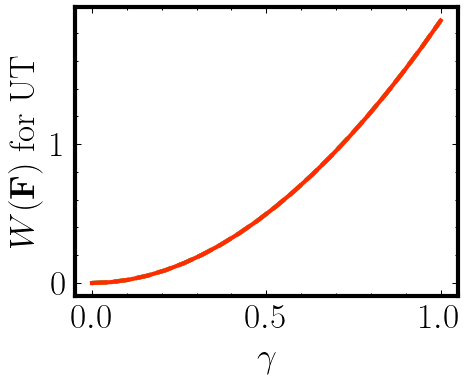

0
1
2


/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipy

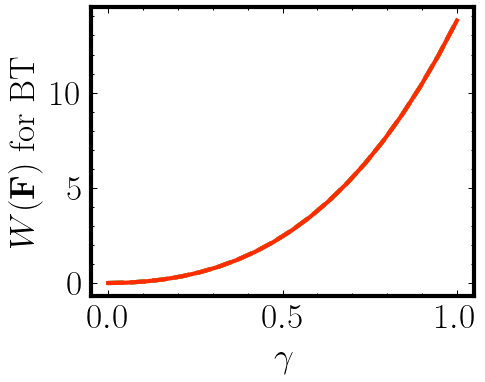

0
1
2


/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipy

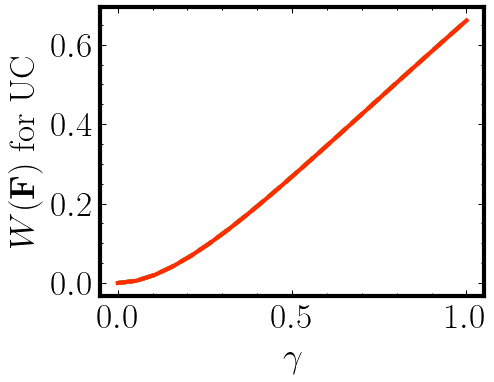

0
1
2


/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipy

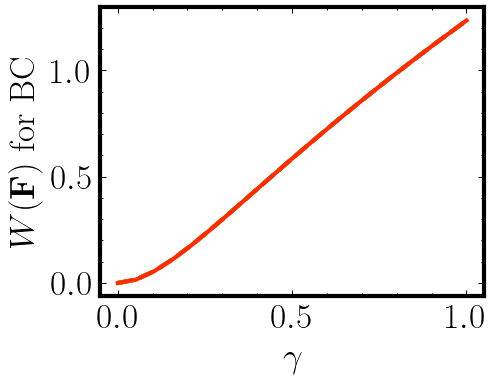

0
1
2


/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipy

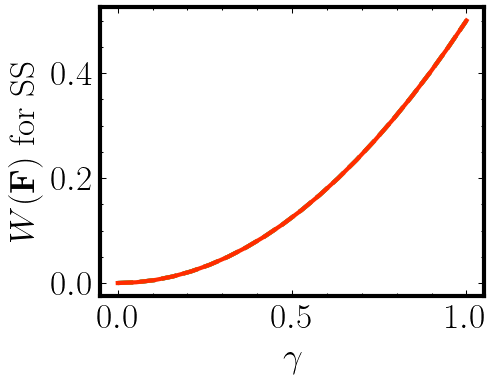

0
1
2


/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipykernel_61776/3755962410.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_W_Flaschel_"+name)
/tmp/ipy

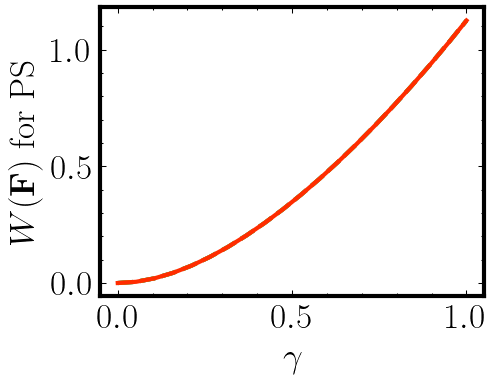

In [9]:
num = 20
gamma = np.linspace(0,1,num=num)
# plt.figure()
for matrix in matrix_functions:
    fig = plt.figure()
    ax = plt.subplot(111)
    name = str(matrix).split("_")[1].split(" ")[0]
    for j, model in enumerate(NH_models):
        psi = np.zeros((num,))
        psi_pred = np.zeros((num,))
        for i in range(0,num):
            psi[i] = compute_psi(F, gamma[i], NH_baseline, matrix) 
            psi_pred[i] = compute_psi(F, gamma[i], model, matrix) 
        print(j)
        if j == 0:
            noise_level = '$0$ %'
        if j == 1:
            noise_level = '$10^{-3}$ %'
        if j == 2:
            noise_level = '$10^{-4}$ %'
        ax.plot(gamma, psi_pred , '--', linewidth=2, label='Prediction for noise level %s'%noise_level)
    ax.plot(gamma, psi, linewidth=2, label='Baseline for Neo-Hookean')
    ax.set_xlabel("$\gamma$")
    ax.set_ylabel("$W(\mathbf{F})$ for "+name)
    plt.savefig("NH_W_Flaschel_"+name)
    plt.show()

0
1
2


/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipy

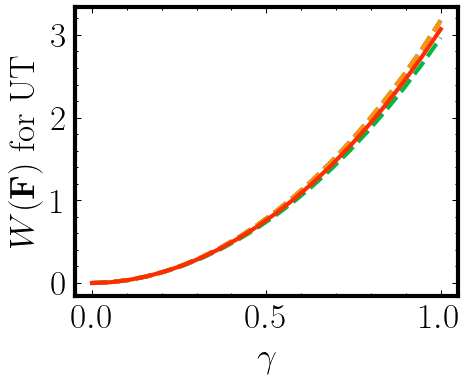

0
1
2


/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipy

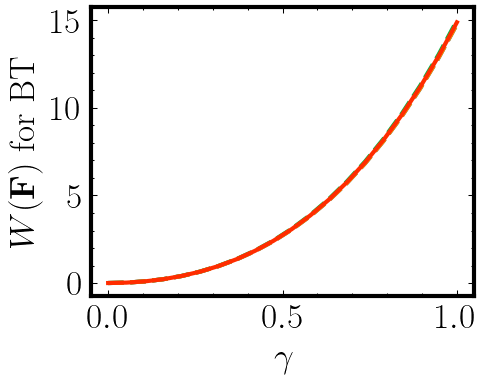

0
1
2


/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipy

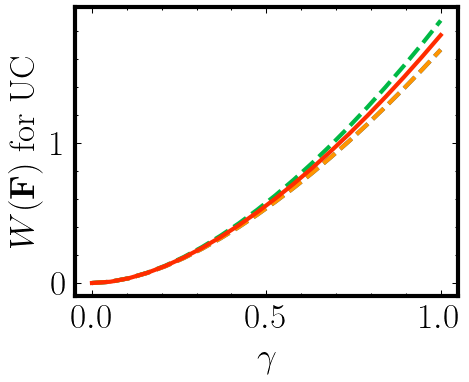

0
1
2


/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipy

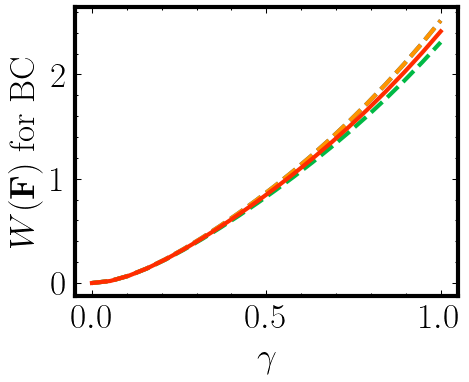

0
1
2


/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipy

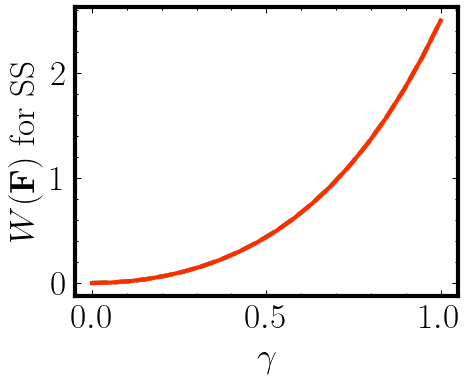

0
1
2


/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipykernel_61776/3535295549.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_W_Flaschel_"+name)
/tmp/ipy

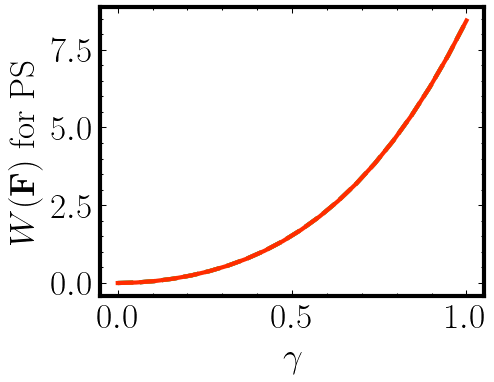

In [10]:
num = 20
gamma = np.linspace(0,1,num=num)
plt.figure()
for matrix in matrix_functions:
    name = str(matrix).split("_")[1].split(" ")[0]
    for j, model in enumerate(IS_models):
        psi = np.zeros((num,))
        psi_pred = np.zeros((num,))
        for i in range(0,num):
            psi[i] = compute_psi(F, gamma[i], IS_baseline, matrix) 
            psi_pred[i] = compute_psi(F, gamma[i], model, matrix) 
        print(j)
        if j == 0:
            noise_level = '$0$ %'
        if j == 1:
            noise_level = '$10^{-3}$ %'
        if j == 2:
            noise_level = '$10^{-4}$ %'
        plt.plot(gamma, psi_pred , '--', linewidth=2, label='Prediction for noise level %s'%noise_level)
    plt.plot(gamma, psi, linewidth=2, label='Baseline for Isihara')
    plt.xlabel("$\gamma$")
    plt.ylabel("$W(\mathbf{F})$ for "+name)
    plt.savefig("IS_W_Flaschel_"+name)
    plt.show()

0
1
2


/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykern

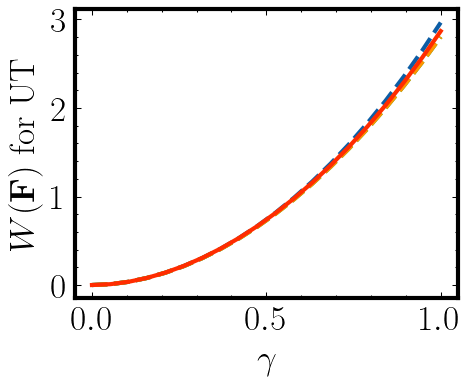

0
1
2


/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykern

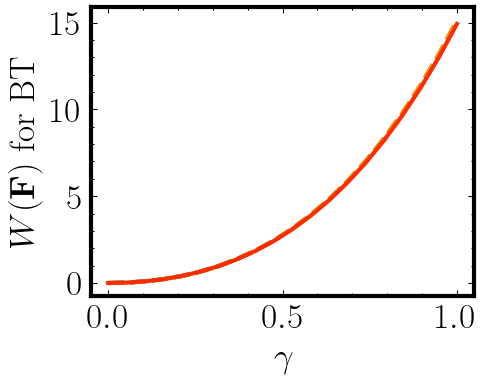

0
1
2


/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykern

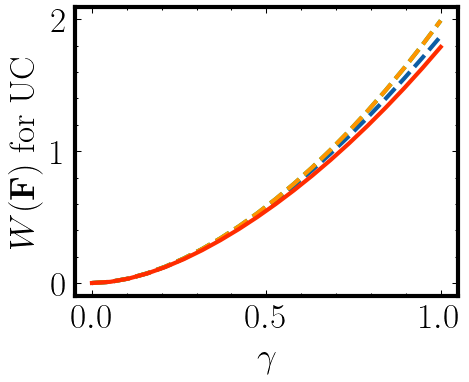

0
1
2


/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykern

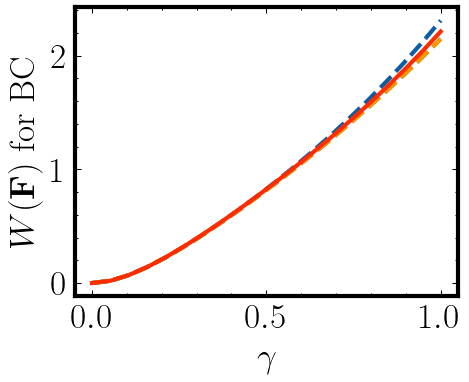

0
1
2


/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykern

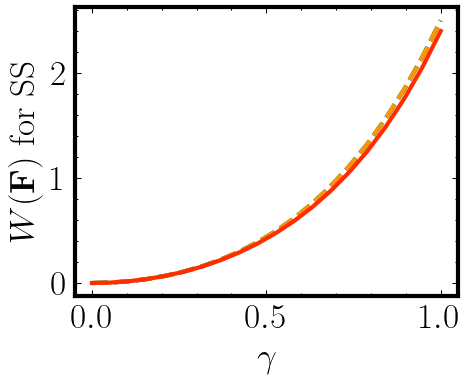

0
1
2


/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykernel_61776/804366184.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_W_Flaschel_"+name)
/tmp/ipykern

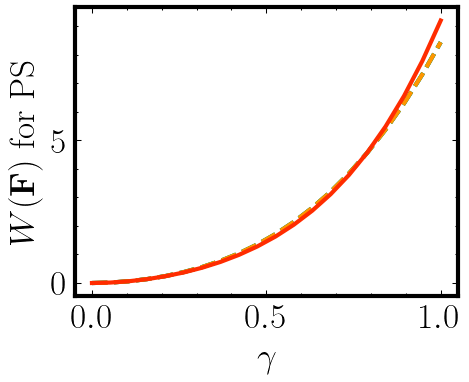

In [11]:
num = 20
gamma = np.linspace(0,1,num=num)
plt.figure()
for matrix in matrix_functions:
    name = str(matrix).split("_")[1].split(" ")[0]
    for j, model in enumerate(HW_models):
        psi = np.zeros((num,))
        psi_pred = np.zeros((num,))
        for i in range(0,num):
            psi[i] = compute_psi(F, gamma[i], HW_baseline, matrix) 
            psi_pred[i] = compute_psi(F, gamma[i], model, matrix) 
        print(j)
        if j == 0:
            noise_level = '$0$ %'
        if j == 1:
            noise_level = '$10^{-3}$ %'
        if j == 2:
            noise_level = '$10^{-4}$ %'
        plt.plot(gamma, psi_pred , '--', linewidth=2, label='Prediction for noise level %s'%noise_level)
    plt.plot(gamma, psi, linewidth=2, label='Baseline for Haines-Wilson')
    plt.xlabel("$\gamma$")
    plt.ylabel("$W(\mathbf{F})$ for "+name)
    plt.savefig("HW_W_Flaschel_"+name)
    plt.show()

0
1
2


/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipy

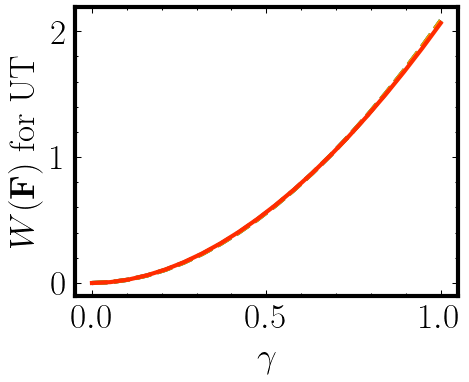

0
1
2


/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipy

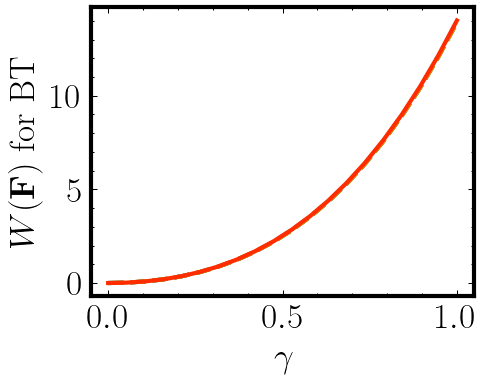

0
1
2


/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipy

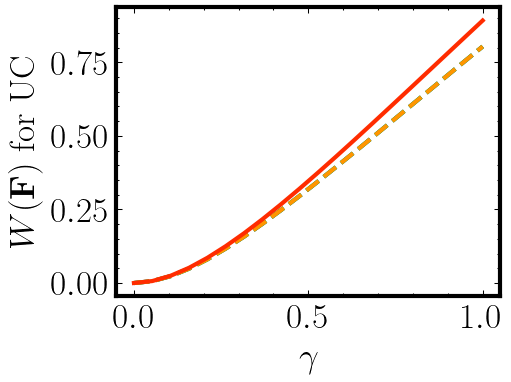

0
1
2


/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipy

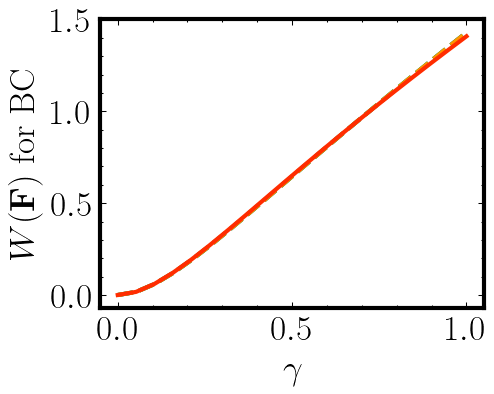

0
1
2


/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipy

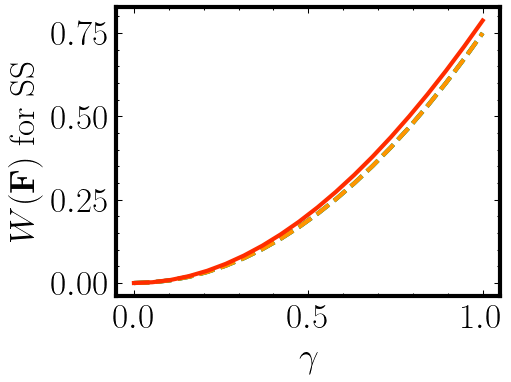

0
1
2


/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipykernel_61776/1426544769.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_W_Flaschel_"+name)
/tmp/ipy

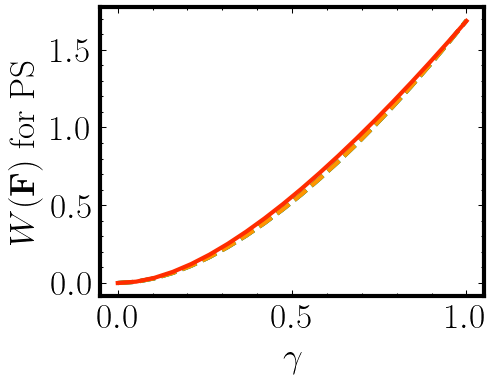

In [12]:
num = 20
gamma = np.linspace(0,1,num=num)
plt.figure()
for matrix in matrix_functions:
    name = str(matrix).split("_")[1].split(" ")[0]
    for j, model in enumerate(GT_models):
        psi = np.zeros((num,))
        psi_pred = np.zeros((num,))
        for i in range(0,num):
            psi[i] = compute_psi(F, gamma[i], GT_baseline, matrix) 
            psi_pred[i] = compute_psi(F, gamma[i], model, matrix) 
        print(j)
        if j == 0:
            noise_level = '$0$ %'
        if j == 1:
            noise_level = '$10^{-3}$ %'
        if j == 2:
            noise_level = '$10^{-4}$ %'
        plt.plot(gamma, psi_pred , '--', linewidth=2, label='Prediction for noise level %s'%noise_level)
    plt.plot(gamma, psi, linewidth=2, label='Baseline for Gent-Thomas')
    plt.xlabel("$\gamma$")
    plt.ylabel("$W(\mathbf{F})$ for "+name)
    # plt.ylim(-15, 200)
    # plt.legend(fontsize=9)
    plt.savefig("GT_W_Flaschel_"+name)
    plt.show()

0
1
2


/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipy

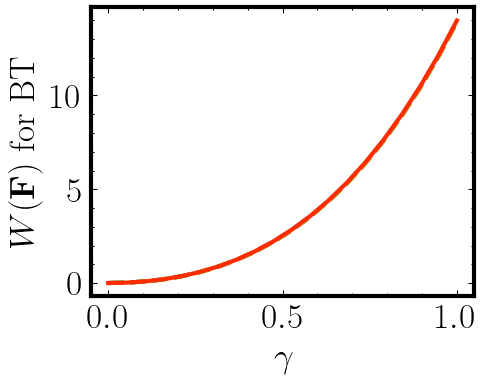

0
1
2


/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipy

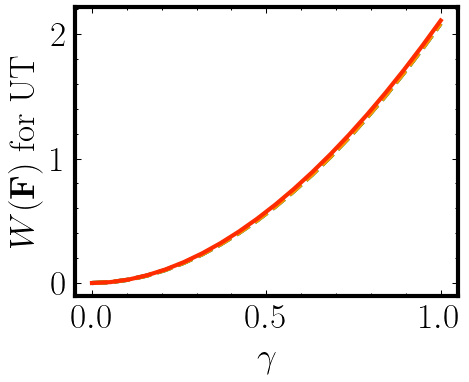

0
1
2


/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipy

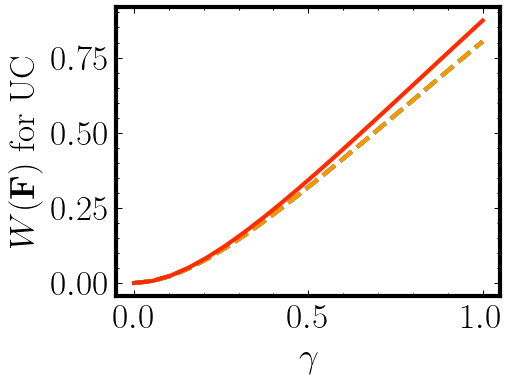

0
1
2


/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipy

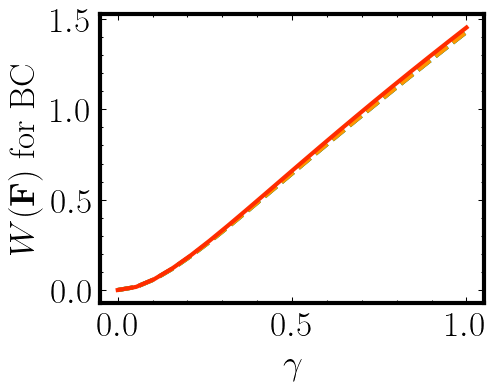

0
1
2


/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipy

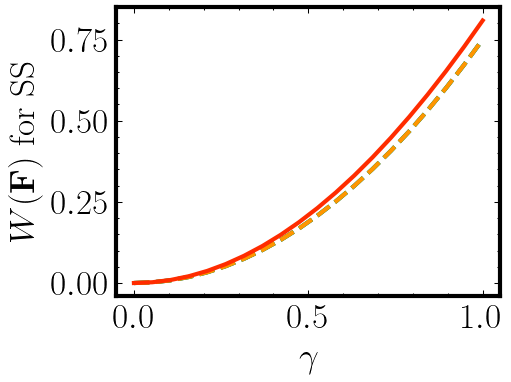

0
1
2


/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipykernel_61776/2737899484.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_W_Flaschel_"+name)
/tmp/ipy

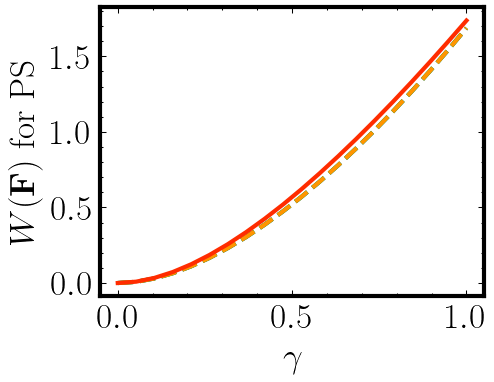

In [13]:
num = 20
gamma = np.linspace(0,1,num=num)
plt.figure()
matrix_functionsOG = [F_BT, F_UT, F_UC, F_BC, F_SS, F_PS]

for matrix in matrix_functionsOG:
    name = str(matrix).split("_")[1].split(" ")[0]
    for j, model in enumerate(OG_models):
        psi = np.zeros((num,))
        psi_pred = np.zeros((num,))
        for i in range(0,num):
            psi[i] = compute_psi(F, gamma[i], OG_baseline, matrix) 
            psi_pred[i] = compute_psi(F, gamma[i], model, matrix) 
        print(j)
        if j == 0:
            noise_level = '$0$ %'
        if j == 1:
            noise_level = '$10^{-3}$ %'
        if j == 2:
            noise_level = '$10^{-4}$ %'
        plt.plot(gamma, psi_pred , '--', linewidth=2, label='Prediction for noise level %s'%noise_level)
    plt.plot(gamma, psi, linewidth=2, label='Baseline for Ogden')
    plt.xlabel("$\gamma$")
    plt.ylabel("$W(\mathbf{F})$ for "+name)
    # plt.ylim(-15, 200)
    # plt.legend(fontsize=9)
    plt.savefig("OG_W_Flaschel_"+name)
    plt.show()

0
1
2


/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/i

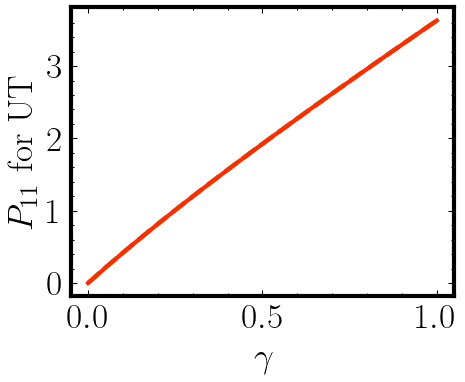

0
1
2


/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)


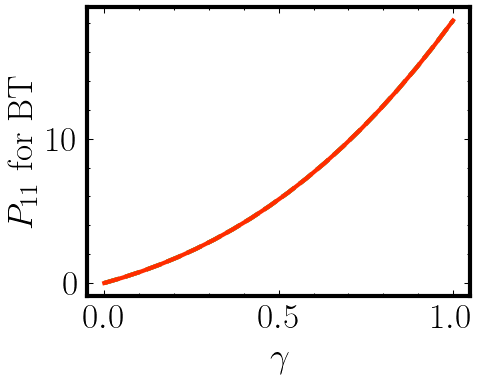

0
1
2


/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/i

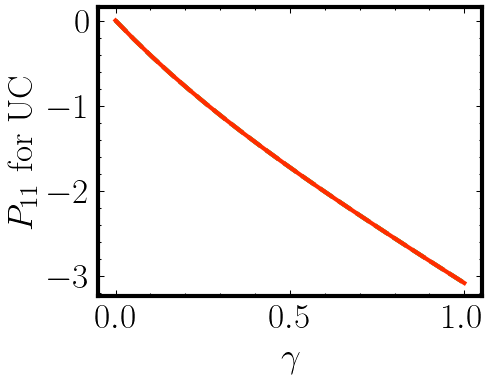

0
1
2


/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)


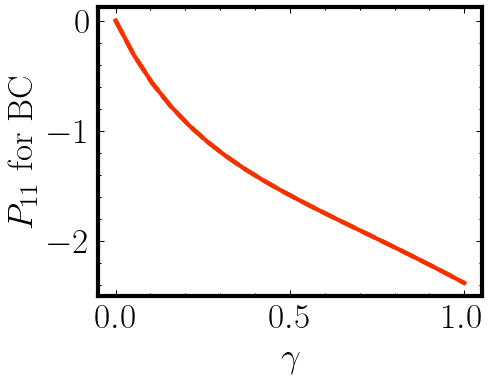

0
1
2


/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)


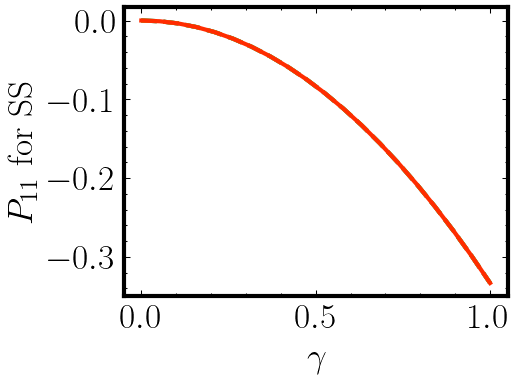

0
1
2


/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3120531779.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("NH_P11_Flaschel_"+name)


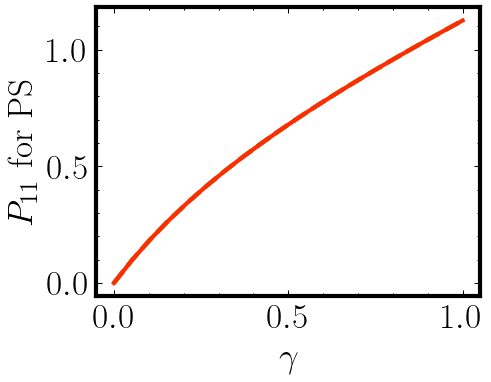

In [14]:
num = 20
gamma = np.linspace(0,1,num=num)
plt.figure()
for matrix in matrix_functions:
    name = str(matrix).split("_")[1].split(" ")[0]
    for j, model in enumerate(NH_models):
        psi = np.zeros((num,))
        psi_pred = np.zeros((num,))
        for i in range(0,num):
            psi[i] = compute_P11(F, gamma[i], NH_baseline, matrix) 
            psi_pred[i] = compute_P11(F, gamma[i], model, matrix) 
        print(j)
        if j == 0:
            noise_level = '$0$ %'
        if j == 1:
            noise_level = '$10^{-3}$ %'
        if j == 2:
            noise_level = '$10^{-4}$ %'
        plt.plot(gamma, psi_pred , '--', linewidth=2, label='Prediction for noise level %s'%noise_level)
    plt.plot(gamma, psi, linewidth=2, label='Baseline for Neo-Hookean')
    plt.xlabel("$\gamma$")
    plt.ylabel("$P_{11}$ for "+name)
    # plt.ylim(-15, 200)
    # plt.legend(fontsize=9)
    plt.savefig("NH_P11_Flaschel_"+name)
    plt.show()

0
1
2


/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)


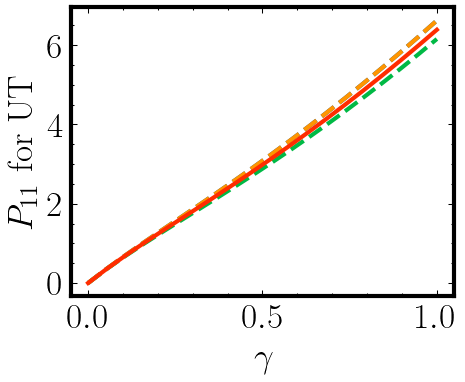

0
1
2


/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)


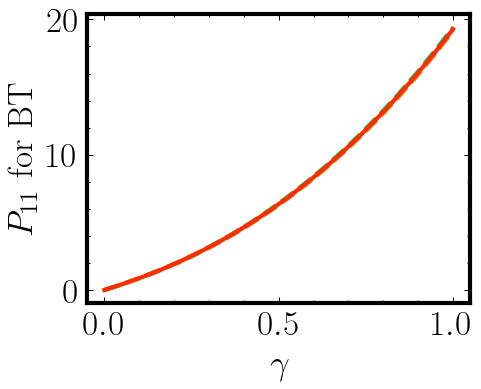

0
1
2


/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)


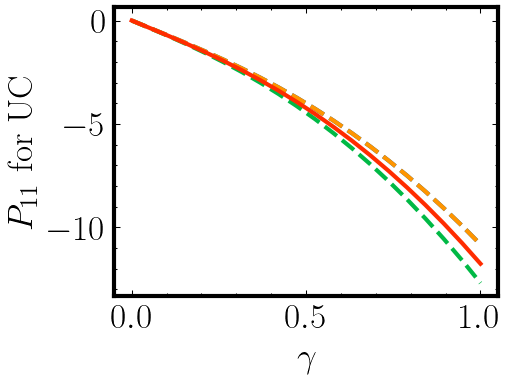

0
1
2


/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)


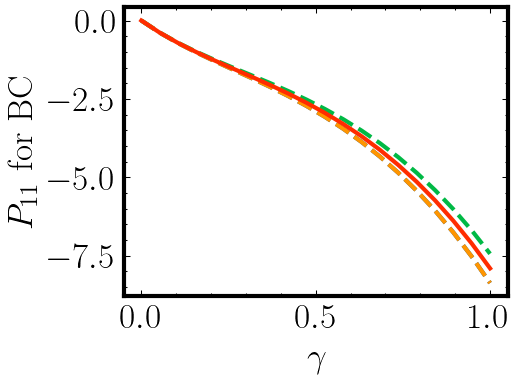

0
1
2


/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)


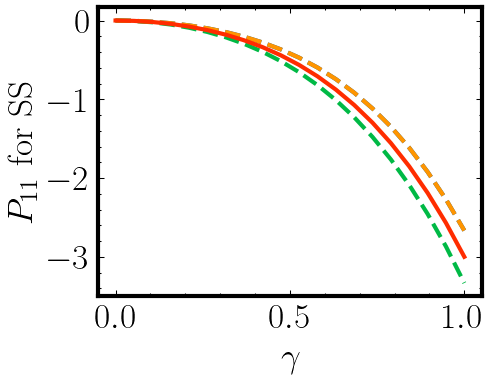

0
1
2


/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3053083619.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("IS_P11_Flaschel_"+name)


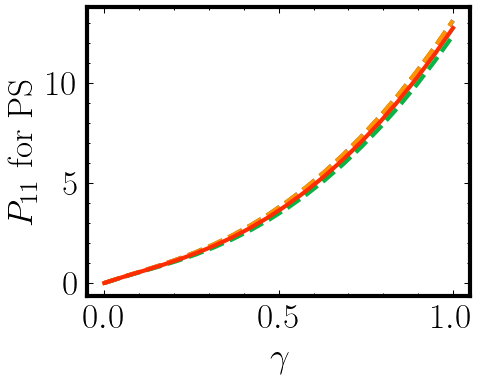

In [15]:
num = 20
gamma = np.linspace(0,1,num=num)
plt.figure()
for matrix in matrix_functions:
    name = str(matrix).split("_")[1].split(" ")[0]
    for j, model in enumerate(IS_models):
        psi = np.zeros((num,))
        psi_pred = np.zeros((num,))
        for i in range(0,num):
            psi[i] = compute_P11(F, gamma[i], IS_baseline, matrix) 
            psi_pred[i] = compute_P11(F, gamma[i], model, matrix) 
        print(j)
        if j == 0:
            noise_level = '$0$ %'
        if j == 1:
            noise_level = '$10^{-3}$ %'
        if j == 2:
            noise_level = '$10^{-4}$ %'
        plt.plot(gamma, psi_pred , '--', linewidth=2, label='Prediction for noise level %s'%noise_level)
    plt.plot(gamma, psi, linewidth=2, label='Baseline for Isihara')
    plt.xlabel("$\gamma$")
    plt.ylabel("$P_{11}$ for "+name)
    # plt.ylim(-15, 200)
    # plt.legend(fontsize=9)
    plt.savefig("IS_P11_Flaschel_"+name)
    plt.show()

0
1
2


/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)


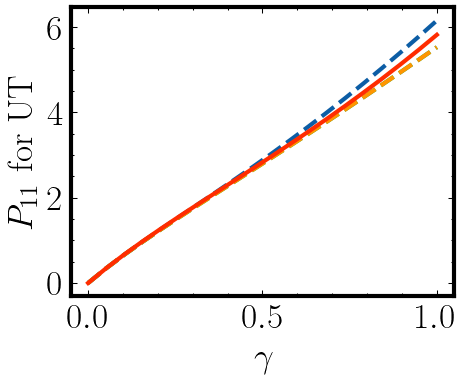

0
1
2


/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)


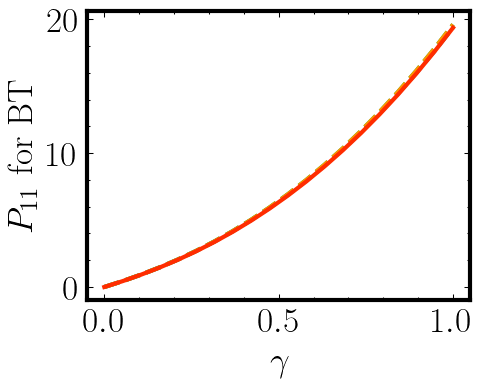

0
1
2


/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)


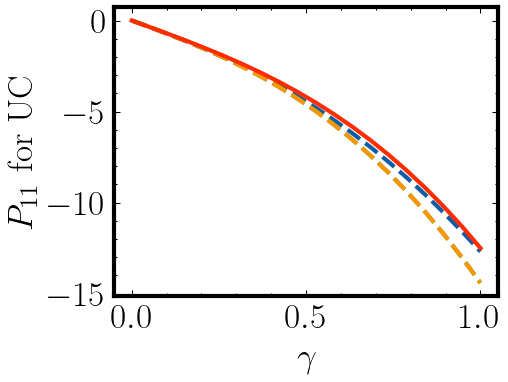

0
1
2


/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)


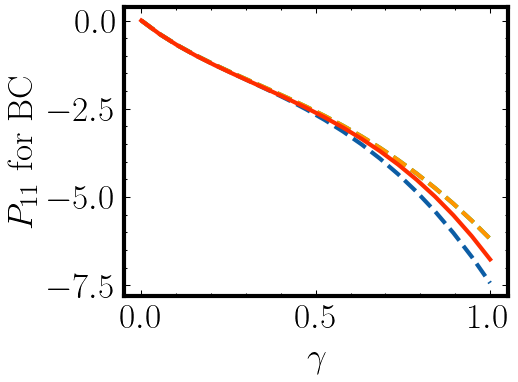

0
1
2


/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)


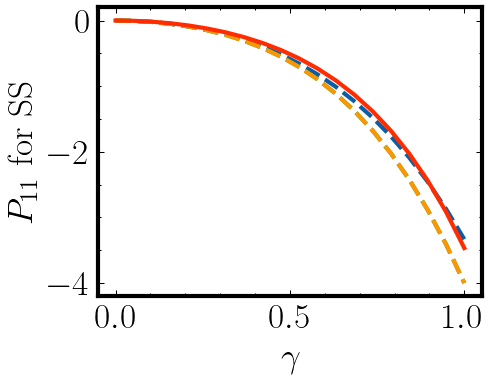

0
1
2


/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3456847310.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("HW_P11_Flaschel_"+name)


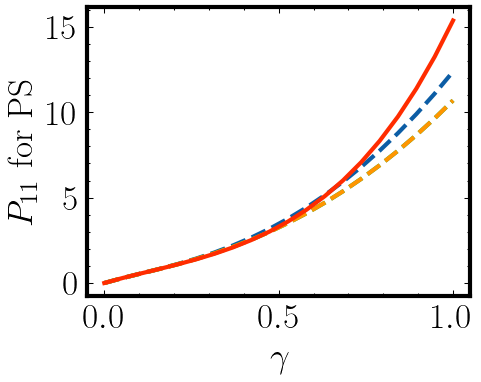

In [16]:
num = 20
gamma = np.linspace(0,1,num=num)
plt.figure()
for matrix in matrix_functions:
    name = str(matrix).split("_")[1].split(" ")[0]
    for j, model in enumerate(HW_models):
        psi = np.zeros((num,))
        psi_pred = np.zeros((num,))
        for i in range(0,num):
            psi[i] = compute_P11(F, gamma[i], HW_baseline, matrix) 
            psi_pred[i] = compute_P11(F, gamma[i], model, matrix) 
        print(j)
        if j == 0:
            noise_level = '$0$ %'
        if j == 1:
            noise_level = '$10^{-3}$ %'
        if j == 2:
            noise_level = '$10^{-4}$ %'
        plt.plot(gamma, psi_pred , '--', linewidth=2, label='Prediction for noise level %s'%noise_level)
    plt.plot(gamma, psi, linewidth=2, label='Baseline for Haines-Wilson')
    plt.xlabel("$\gamma$")
    plt.ylabel("$P_{11}$ for "+name)
    # plt.ylim(-15, 200)
    # plt.legend(fontsize=9)
    plt.savefig("HW_P11_Flaschel_"+name)
    plt.show()

0
1
2


/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)


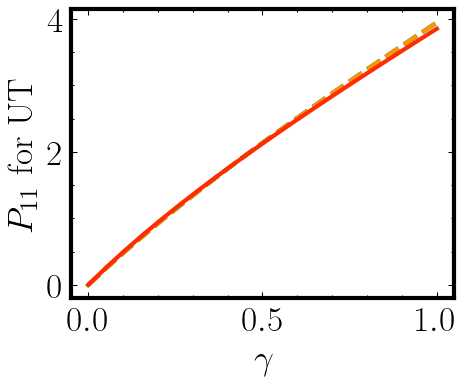

0
1
2


/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)


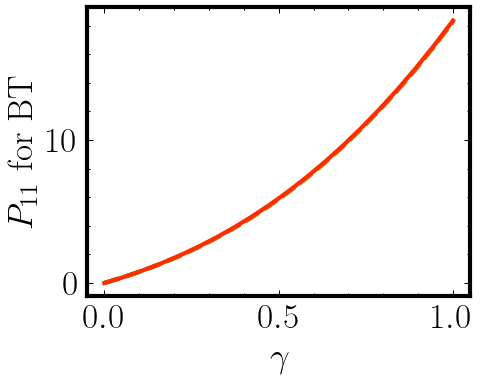

0
1
2


/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)


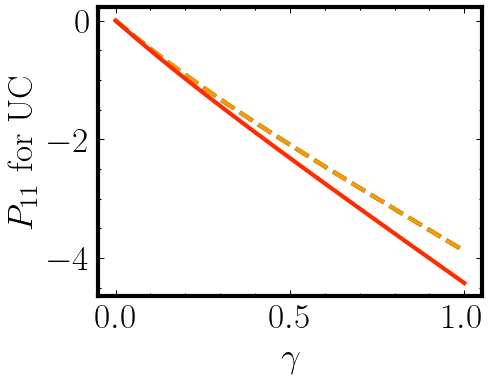

0
1
2


/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)


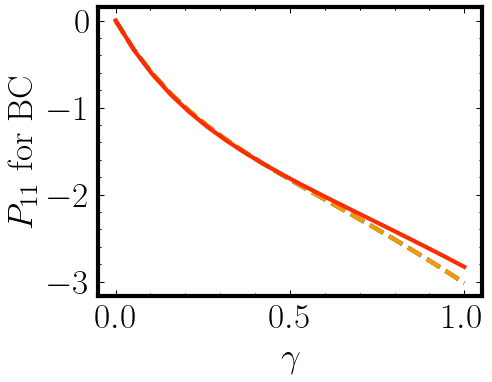

0
1
2


/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)


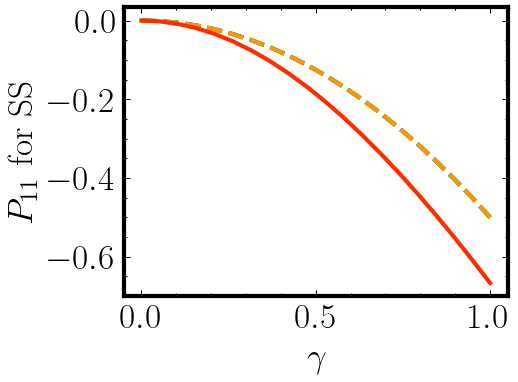

0
1
2


/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)
/tmp/ipykernel_61776/2581973273.py:25: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("GT_P11_Flaschel_"+name)


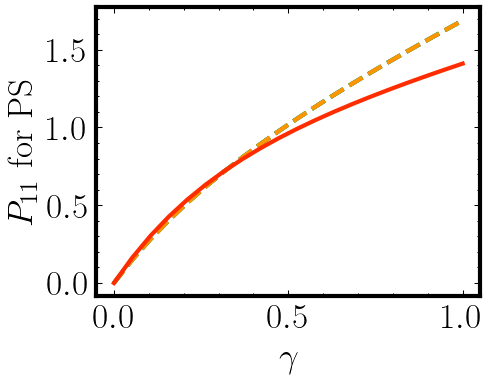

In [17]:
num = 20
gamma = np.linspace(0,1,num=num)
plt.figure()
for matrix in matrix_functions:
    name = str(matrix).split("_")[1].split(" ")[0]
    for j, model in enumerate(GT_models):
        psi = np.zeros((num,))
        psi_pred = np.zeros((num,))
        for i in range(0,num):
            psi[i] = compute_P11(F, gamma[i], GT_baseline, matrix) 
            psi_pred[i] = compute_P11(F, gamma[i], model, matrix) 
        print(j)
        if j == 0:
            noise_level = '$0$ %'
        if j == 1:
            noise_level = '$10^{-3}$ %'
        if j == 2:
            noise_level = '$10^{-4}$ %'
        plt.plot(gamma, psi_pred , '--', linewidth=2, label='Prediction for noise level %s'%noise_level)
    plt.plot(gamma, psi, linewidth=2, label='Baseline for Gent-Thomas')
    plt.xlabel("$\gamma$")
    plt.ylabel("$P_{11}$ for "+name)
    # plt.ylim(-15, 200)
    # plt.legend(fontsize=9)
    plt.savefig("GT_P11_Flaschel_"+name)
    plt.show()

0
1
2


/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)


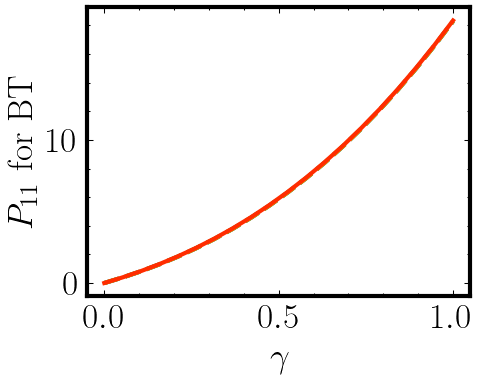

0
1
2


/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)


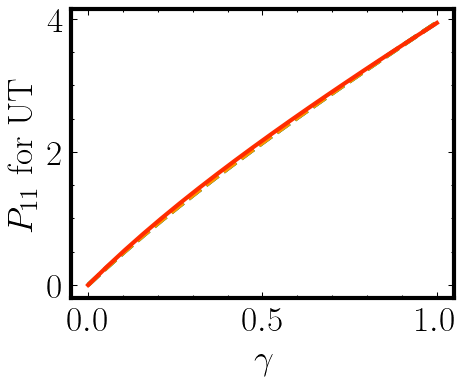

0
1
2


/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)


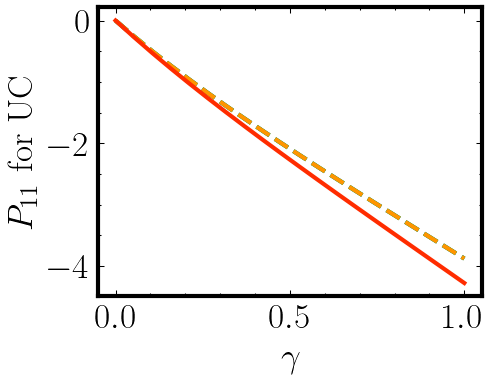

0
1
2


/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)


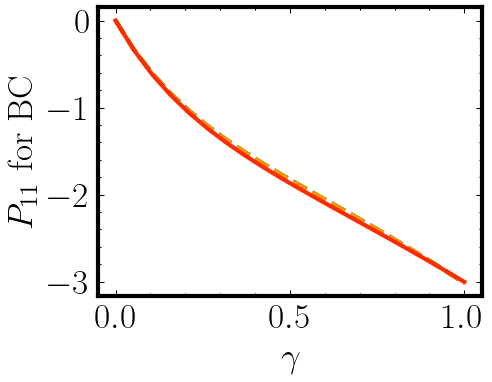

0
1
2


/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)


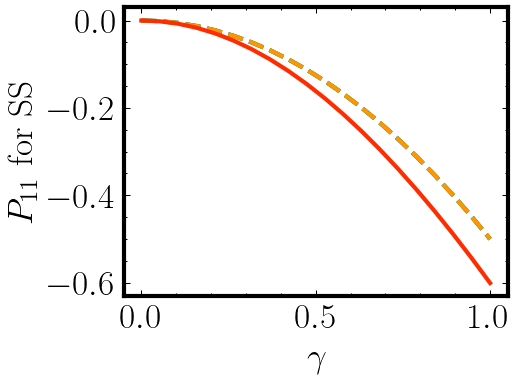

0
1
2


/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)
/tmp/ipykernel_61776/3434483586.py:27: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("OG_P11_Flaschel_"+name)


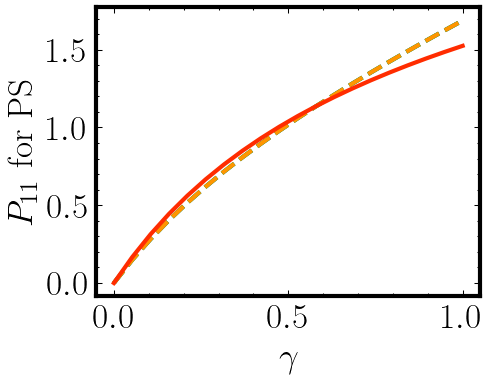

In [18]:
num = 20
gamma = np.linspace(0,1,num=num)
plt.figure()
matrix_functionsOG = [F_BT, F_UT, F_UC, F_BC, F_SS, F_PS]

for matrix in matrix_functionsOG:
    name = str(matrix).split("_")[1].split(" ")[0]
    for j, model in enumerate(OG_models):
        psi = np.zeros((num,))
        psi_pred = np.zeros((num,))
        for i in range(0,num):
            psi[i] = compute_P11(F, gamma[i], OG_baseline, matrix) 
            psi_pred[i] = compute_P11(F, gamma[i], model, matrix) 
        print(j)
        if j == 0:
            noise_level = '$0$ %'
        if j == 1:
            noise_level = '$10^{-3}$ %'
        if j == 2:
            noise_level = '$10^{-4}$ %'
        plt.plot(gamma, psi_pred , '--', linewidth=2, label='Prediction for noise level %s'%noise_level)
    plt.plot(gamma, psi, linewidth=2, label='Baseline for Ogden')
    plt.xlabel("$\gamma$")
    plt.ylabel("$P_{11}$ for "+name)
    # plt.ylim(-15, 200)
    # plt.legend(fontsize=9)
    plt.savefig("OG_P11_Flaschel_"+name)
    plt.show()

In [19]:
asdas

NameError: name 'asdas' is not defined

In [ ]:
from sympy import Pow, MatrixSymbol, Trace, log, MatMul, Determinant, MatPow

In [ ]:
def F_UT(gamma):
    a = 1 + float(gamma)
    b = 1.
    return sympy.diag(a, b, 1.)

def F_BT(gamma):
    a = 1 + float(gamma)
    b = 1 + float(gamma)
    return sympy.diag(a, b, 1.)

def F_UC(gamma):
    a = 1./(1 + float(gamma))
    b = 1.
    return sympy.diag(a, b, 1.)

def F_BC(gamma):
    a = 1./(1 + float(gamma))
    b = 1./(1 + float(gamma)/2)
    return sympy.diag(a, b, 1.)

def F_SS(gamma):
    a = 1
    b = 1.
    off_Diag = sympy.zeros(3)
    off_Diag[0,1] = float(gamma)
    return sympy.diag(a, b, 1.) + off_Diag

def F_PS(gamma):
    a = 1. + float(gamma)
    b = 1./(1. + float(gamma))
    return sympy.diag(a, b, 1.)

In [ ]:
# Compute invariants of C

def get_J_explicit(Fparam):
    F = MatrixSymbol("F",2,2).as_explicit()
    C = F.T * F
    J = sympy.Determinant(F)
    return sympy.simplify(J.subs({F:Fparam}))
   
def get_I1_explicit(Fparam):
    F  = MatrixSymbol("F",3,3)
    I1 = Trace(MatrixSymbol("F",3,3).T.as_explicit()*MatrixSymbol("F",3,3).as_explicit())
    return sympy.simplify(I1.subs({F:Fparam}))
    
def get_I2_explicit(Fparam):
    F  = MatrixSymbol("F",3,3)
    I2 = 0.5*(Pow(Trace(MatMul(MatrixSymbol("F",3,3).T.as_explicit(),MatrixSymbol("F",3,3).as_explicit())),2) - Trace(MatPow(MatMul(MatrixSymbol("F",3,3).T.as_explicit(),MatrixSymbol("F",3,3).as_explicit()),2)))
    return sympy.simplify(I2.subs({F:Fparam}))

In [ ]:
def F_new1(gamma):
    a = sympy.sqrt(float(gamma))
    b = sympy.sqrt((4- float(gamma))/(1 + 2*float(gamma)))
    return sympy.diag(a, b, 1.)

def F_new2(gamma):
    a = sympy.sqrt(float(gamma)/(2*float(gamma)-1))
    b = sympy.sqrt(float(gamma))
    return sympy.diag(a, b, 1.)

def F_new3(gamma):
    a = sympy.sqrt((5- float(gamma))/(1 + 3*float(gamma)))
    b = sympy.sqrt(float(gamma))
    return sympy.diag(a, b, 1.)

In [ ]:
N = 10
gamma = np.linspace(0,1,num=N)
loading_conditions = [F_UT, F_BT, F_UC, F_BC, F_SS, F_PS, F_new1, F_new2, F_new3]
loading_condition_names = ['F_{UT}', 'F_{BT}','F_{UC}','F_{BC}','F_{SS}','F_{PS}', 'F_{N1}', 'F_{N2}', 'F_{N3}']

J  = np.zeros((len(loading_conditions),len(gamma)))
I1 = np.zeros((len(loading_conditions),len(gamma)))
I2 = np.zeros((len(loading_conditions),len(gamma)))


for j, load in enumerate(loading_conditions):
    if j==6:
        gamma = np.linspace(0,1,num=N)
    elif j==7:
        gamma = np.linspace(0.51,1,num=N)
    elif j==8:
        gamma = np.linspace(0,1,num=N)
    else:
        gamma = np.linspace(0,1,num=N)
    for i in range(gamma.shape[0]):
        F_param = load(gamma[i])
        J[j,i]  = get_J_explicit(F_param)
        I1[j,i] = get_I1_explicit(F_param)
        I2[j,i] = get_I2_explicit(F_param)


In [ ]:
plt.figure()
for i in range(len(loading_conditions)-3):
    plt.plot(I1[i]-3, I2[i]-3 , '-', linewidth=1, label='$%s$'%loading_condition_names[i])
plt.xlabel("$\Tilde{I}_1-3$")
plt.ylabel("$\Tilde{I}_2-3$")
plt.ylim(-0.5,1)
plt.xlim(-0.5,1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.savefig("deformation_paths_old.png")
plt.show()

plt.figure()
for i in range(len(loading_conditions)):
    plt.plot(I1[i]-3, I2[i]-3 , '-', linewidth=1, label='$%s$'%loading_condition_names[i])
plt.xlabel("$\Tilde{I}_1-3$")
plt.ylabel("$\Tilde{I}_2-3$")
plt.ylim(-0.5,1)
plt.xlim(-0.5,1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.savefig("deformation_paths_new.png")
plt.show()